In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from nn_visualise import *

# Problem: 1D heat equation
$$U_{t} = U_{xx}$$
on $x in [0,1]$, t in $[0,0.3]$ with $U(0,t) = 0,U(1,t) = 0,U(x,0) = f(x)$\
here we take $f(x) = 6sin(\pi x)$
the exact solution is given by $6sin(\pi x)e^{-\pi^{2}t}$

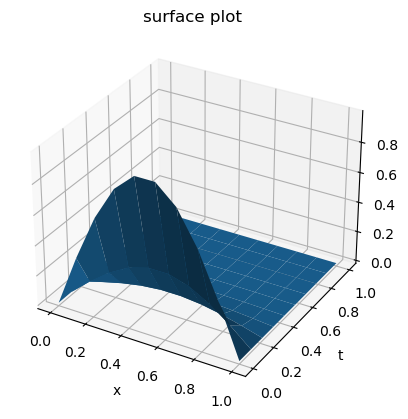

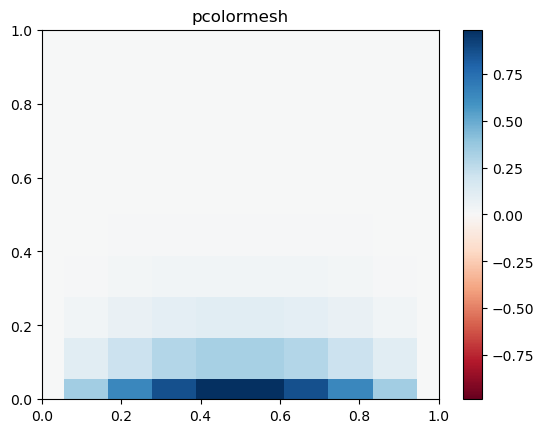

In [26]:
def f(x):
    return np.sin(np.pi*x)
def exact_sol(x,t):
    return np.sin(np.pi*x)*np.exp(-1*(np.pi**2)*t)
    
def mesh_xy_forward(x,t):
    res = np.zeros([x.shape[0],t.shape[0]])
    for i in range(x.shape[0]):
        for j in range(t.shape[0]):
            #print(torch.tensor([x[i,j],t[i,j]]))
            res[i,j] = model.forward(torch.tensor([x[i,j],t[i,j]]).float())
    
    return res


def two_D_plot(xs,ys,z):
#     x, y = torch.meshgrid(xs, ys, indexing='xy')
#     z = psi_sol(x,y)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z)
    plt.title("surface plot ")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()

    z_min, z_max = -np.abs(z).max(), np.abs(z).max()

    fig, ax = plt.subplots()

    c = ax.pcolormesh(xs, ys, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    ax.set_title('pcolormesh')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    
    plt.show()


    fig = go.Figure(data=[go.Surface(z=z, x=xs, y=ys)])
    fig.update_layout(title='surface plot ', autosize=False,
                      width=500, height=500,
                      margin=dict(l=65, r=50, b=65, t=90))
    fig.show()
    
xs = np.linspace(0,1,10)
ts = np.linspace(0,1,10)
x,t = np.meshgrid(xs,ts)
z_mesh = exact_sol(x,t)
two_D_plot(xs,ts,z_mesh)
#print(z_mesh)

In [27]:

'''
this script solves ut = uxx  on [0,1] with u(0,t) = 0, u(1,t) =0
u(x,0) = f(x);
here we take f(x) = 6 sin(pi*x)
'''



class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(2, 50) # there are two features as input: x and t

        self.hidden_1 = nn.Linear(50, 50)
        self.hidden_2= nn.Linear(32, 32)

        self.output = nn.Linear(50,1)

        # Define sigmoid activation and softmax output
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.ReLU = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.input(x)
        x = self.tanh(x)

        x = self.hidden_1(x)
        x = self.tanh(x)
        #x = self.hidden_2(x)
        #x = self.sigmoid(x)

        x = self.output(x)
        return x

###############################################training##############################################################
torch.manual_seed(1024)
step = 10

model = Model()


model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)

num_epochs = 2000

loss_list = []

for i in range(num_epochs):
    #print(i)
    loss = torch.tensor([[0.]])
    optimizer.zero_grad()


    for t in np.linspace(0,1,step):
        for x in np.linspace(0,1,step):



            x= float(x)
            t = float(t)
#             y_pred = model.forward(torch.tensor([x,t]))
#             y_minus_h = model.forward(torch.tensor([x-h,t]))
#             y_plus_h = model.forward(torch.tensor([x+h,t]))
#             y_minus_dt = model.forward(torch.tensor([x,t-dt]))
#             y_plus_dt = model.forward(torch.tensor([x,t+dt]))
#             y_2nd_deri_space= (y_plus_h-2*y_pred+y_minus_h)/(h**2)
#             y_1st_deri_time=(y_plus_dt-y_minus_dt)/(2*dt)
            
            x_= torch.tensor([x]).float().requires_grad_(True)
            t_ = torch.tensor([t]).float().requires_grad_(True)
            #psi_pred = model.forward(torch.tensor([x,y]))
            
            xt = torch.cat((x_, t_), dim=0)
            psi_pred = model(xt)

            # compute the derivative of psi_pred with respect to x using autograd
            dpsi_pred_dxt = torch.autograd.grad(psi_pred, xt, grad_outputs=torch.ones_like(psi_pred), create_graph=True, retain_graph=True, only_inputs=True)[0]
            
            d2psi_pred_dxt2 = torch.autograd.grad(dpsi_pred_dxt, xt, grad_outputs=torch.ones_like(dpsi_pred_dxt), create_graph=True)[0]
            
            dpsi_dx = dpsi_pred_dxt[0]
            dpsi_dt = dpsi_pred_dxt[1]
            dpsi_dt = torch.tensor([dpsi_dt])
            d2psi_pred_dx2 =torch.tensor([d2psi_pred_dxt2[0]])
            
            #d2psi_pred_dt2 = torch.tensor([d2psi_pred_dxt2[1]])
            #y_1st_deri = (y_plus_h-y_minus_h)/(2*h)

            if x==0 or x ==1:
                loss +=1000* F.mse_loss(psi_pred, torch.tensor([float(0)]))

            elif t ==0 :
                #print(y_pred)
                loss +=1000* F.mse_loss(psi_pred, torch.tensor([f(x)]).float())
            else:
                loss += 1*F.mse_loss(dpsi_dt,  d2psi_pred_dx2)
            
    loss.backward()
    optimizer.step()
    loss_list.append(loss.detach().numpy())


In [28]:
loss_list = [i[0][0] for i in loss_list]
loss_list

[3890.741,
 376977.9,
 31436.855,
 158548.66,
 141776.52,
 24724.672,
 16461.273,
 71287.57,
 67146.305,
 19379.691,
 5174.5923,
 32757.19,
 44502.125,
 22042.86,
 3559.0679,
 11545.845,
 26692.861,
 22747.117,
 7449.2188,
 4070.4097,
 13953.143,
 18408.25,
 10463.502,
 3217.7405,
 6580.0684,
 12609.878,
 10613.352,
 4320.193,
 3639.2827,
 8026.818,
 8980.68,
 5015.899,
 2965.3179,
 5459.1064,
 7184.1836,
 5009.7417,
 2940.6697,
 4172.6436,
 5701.6147,
 4540.5347,
 2998.4912,
 3694.6272,
 4849.4307,
 4166.0986,
 3066.6375,
 3515.6348,
 4299.681,
 3804.6748,
 3120.8962,
 3527.9124,
 3992.479,
 3507.458,
 3062.7297,
 3403.6348,
 3613.271,
 3218.8062,
 3040.8855,
 3325.009,
 3328.4412,
 2990.0083,
 2935.7043,
 3076.4167,
 2921.9697,
 2674.0054,
 2691.7822,
 2693.594,
 2528.1047,
 2489.1099,
 2612.551,
 2547.425,
 2465.7952,
 2512.1284,
 2522.4512,
 2413.2915,
 2410.7378,
 2362.075,
 2169.0237,
 2040.5452,
 1841.7069,
 1534.4064,
 1468.6145,
 1373.4711,
 1381.7286,
 1361.7787,
 1335.0782,


# Visualise the result

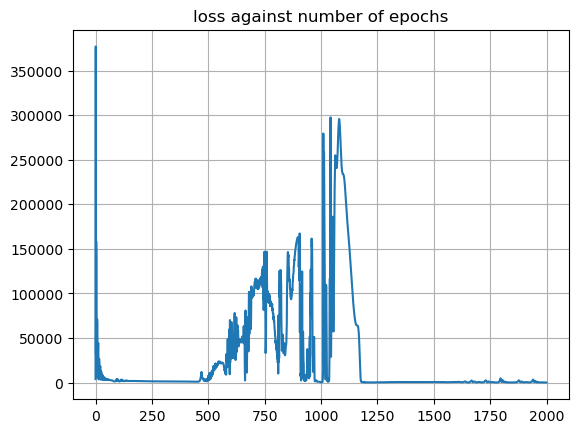

C:\Users\haoyang\AppData\Local\Temp\ipykernel_57952\1948278961.py:8: RuntimeWarning:

divide by zero encountered in log



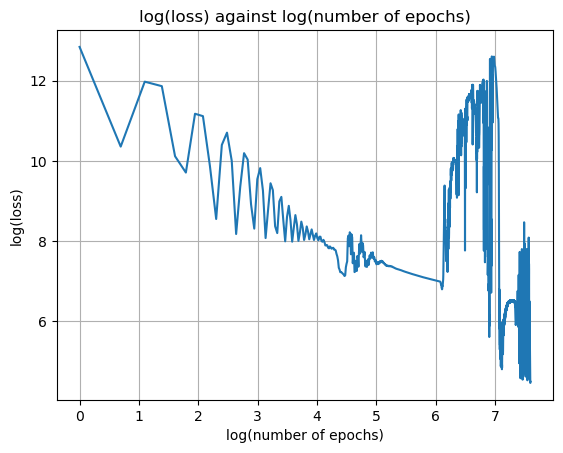

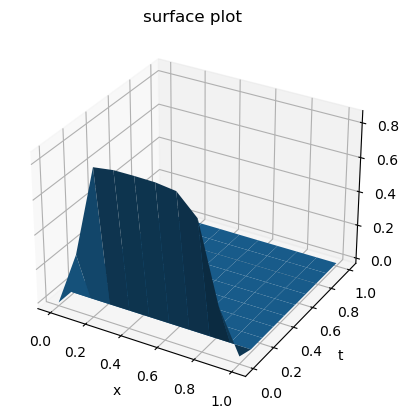

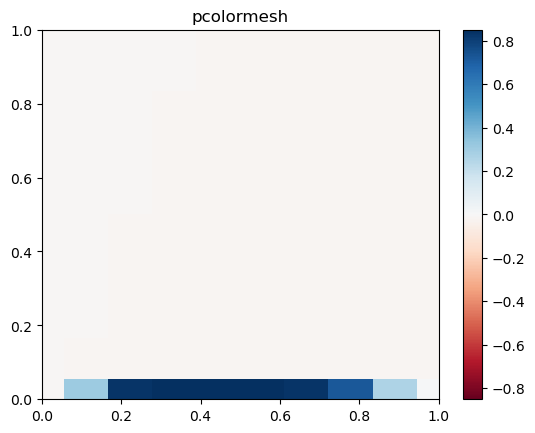

In [29]:
plt.figure()
plt.plot(range(len(loss_list)), loss_list)
plt.title("loss against number of epochs")
plt.grid()
plt.show()

plt.figure()
plt.plot(np.log(range(len(loss_list))), np.log(np.array(loss_list)))
plt.title("log(loss) against log(number of epochs)")
plt.xlabel("log(number of epochs)")
plt.ylabel("log(loss)")
plt.grid()
plt.show()




xs = np.linspace(0,1,10)
ts = np.linspace(0,1,10)
x,t = np.meshgrid(xs,ts)
# exact_z_mesh = exact_sol(x,t)
#two_D_plot(xs,ts,exact_z_mesh)


model_pred_z_mesh =mesh_xy_forward(x,t)
two_D_plot(xs,ts,model_pred_z_mesh)

# Error  plot

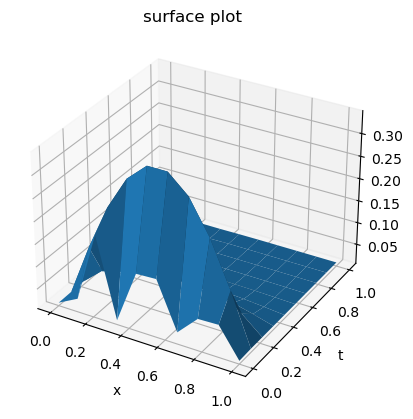

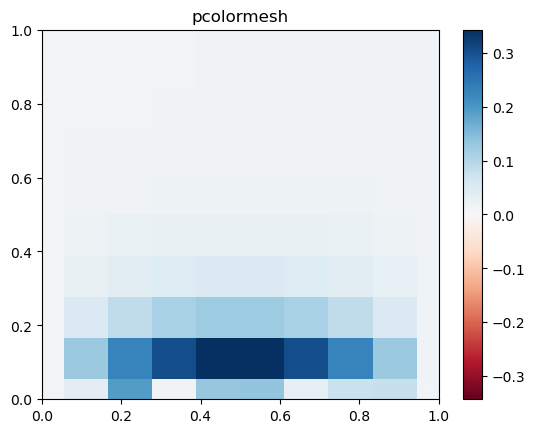

In [30]:
xs = np.linspace(0,1,10)
ts = np.linspace(0,1,10)
x,t = np.meshgrid(xs,ts)
z_mesh = abs(exact_sol(x,t)-mesh_xy_forward(x,t))
two_D_plot(xs,ts,z_mesh)

# Error plot